In [85]:
import pandas as pd
import requests
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
from IPython.display import display

In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

In [3]:
df_gse16 = f"{assets}/GSE161529/GSE161529_DE_oncogenes.csv"
df_gse18 = f"{assets}/GSE180286/GSE180286_DE_oncogenes.csv"

# Load the datasets and tag with dataset source
df_16 = pd.read_csv(df_gse16)
df_16["Dataset"] = "GSE161529"

df_18 = pd.read_csv(df_gse18)
df_18["Dataset"] = "GSE180286"

# Standardize gene column if needed
df_16["gene"] = df_16["gene"].str.upper()
df_18["gene"] = df_18["gene"].str.upper()

In [4]:
# Combine both
combined_df = pd.concat([df_18, df_16], ignore_index=True)

In [5]:
# Save combined file
combined_df.to_csv(f"{assets}/Combined_DE.csv", index=False)
print("Combined_de_genes.csv created successfully.")

Combined_de_genes.csv created successfully.


In [6]:
# Load DGIdb interaction data and extract druggable genes
dgidb_df = pd.read_csv(f"{assets}/interactions.tsv", sep="\t")

In [7]:
# Filter druggable genes: approved or anti-neoplastic
dgidb_filtered = dgidb_df[
    (dgidb_df["approved"] == True) | (dgidb_df["anti_neoplastic"] == True)
]

In [8]:
# Unique druggable gene symbols (uppercased for consistency)
druggable_genes = dgidb_filtered["gene_name"].dropna().str.upper().unique()
druggable_genes

array(['AGTR1', 'KDR', 'KIT', ..., 'PROX1', 'BMPR2', 'HLA-H'],
      dtype=object)

In [9]:
open_targets_df = pd.read_csv(f"{assets}/OpenTargets_Score.csv")

In [10]:
# Filter strong breast cancer associations
open_targets_df = open_targets_df[open_targets_df["OpenTargets_Score"] >= 0.5]

print(f"Number of genes strongly associated with breast cancer (Open Targets): {open_targets_df.shape[0]}")

Number of genes strongly associated with breast cancer (Open Targets): 316


In [11]:
# Merge DE genes with DGIdb and Open Targets info
# Ensure gene symbols uppercase in DE dataframe for consistency
combined_df["Gene"] = combined_df["gene"].str.upper()

# Add DGIdb Status
combined_df["DGIdb Status"] = combined_df["Gene"].apply(lambda x: "Targeted" if x in druggable_genes else "Not Targeted")

In [12]:
combined_df.drop(columns=["gene"], inplace=True)
combined_df

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status
0,0.000000e+00,1.686214,0.081446,GSE180286,PTEN,Targeted
1,0.000000e+00,3.222505,0.089603,GSE180286,CDK4,Targeted
2,0.000000e+00,4.279113,0.062919,GSE180286,CDKN2A,Targeted
3,0.000000e+00,3.952025,0.123942,GSE180286,CDKN1A,Targeted
4,0.000000e+00,4.152696,0.070191,GSE180286,FGFR1,Targeted
...,...,...,...,...,...,...
73,6.880750e-252,1.470827,0.060847,GSE161529,BCL2,Targeted
74,6.852575e-238,2.499320,0.025311,GSE161529,BRCA2,Targeted
75,4.698129e-180,1.058718,0.071020,GSE161529,ATM,Targeted
76,1.056194e-19,2.424174,0.001583,GSE161529,WT1,Targeted


In [13]:
# Merge with Open Targets scores (left join to keep all DE genes)
df = combined_df.merge(open_targets_df, how="left", left_on="Gene", right_on="gene")

# Add breast cancer support flags
df["BreastCancer_Supported"] = df["OpenTargets_Score"].notna()
df["Strong_BreastCancer_Support"] = df["OpenTargets_Score"].fillna(0) >= 0.5

In [14]:
df

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,gene,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support
0,0.000000e+00,1.686214,0.081446,GSE180286,PTEN,Targeted,PTEN,0.774262,True,True
1,0.000000e+00,3.222505,0.089603,GSE180286,CDK4,Targeted,CDK4,0.693263,True,True
2,0.000000e+00,4.279113,0.062919,GSE180286,CDKN2A,Targeted,CDKN2A,0.592468,True,True
3,0.000000e+00,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,NaN,False,False
4,0.000000e+00,4.152696,0.070191,GSE180286,FGFR1,Targeted,FGFR1,0.501992,True,True
...,...,...,...,...,...,...,...,...,...,...
73,6.880750e-252,1.470827,0.060847,GSE161529,BCL2,Targeted,BCL2,0.542606,True,True
74,6.852575e-238,2.499320,0.025311,GSE161529,BRCA2,Targeted,BRCA2,0.901557,True,True
75,4.698129e-180,1.058718,0.071020,GSE161529,ATM,Targeted,ATM,0.810703,True,True
76,1.056194e-19,2.424174,0.001583,GSE161529,WT1,Targeted,NaN,NaN,False,False


In [15]:
# Add FDA approval info from DGIdb data 
# To get FDA approval status, use the dgidb_filtered dataframe:
# Extract gene-wise FDA approval flag

# Prepare dictionary mapping gene -> FDA approved (True/False)
fda_dict = dgidb_filtered.groupby("gene_name")["approved"].max().to_dict()

# Map it onto df
df["FDA_Approved_Drug"] = df["Gene"].map(fda_dict).fillna(False)

In [16]:
df.drop(columns=["gene"], inplace=True)
df

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug
0,0.000000e+00,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,True
1,0.000000e+00,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True,True
2,0.000000e+00,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True,True
3,0.000000e+00,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False,True
4,0.000000e+00,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True,True
...,...,...,...,...,...,...,...,...,...,...
73,6.880750e-252,1.470827,0.060847,GSE161529,BCL2,Targeted,0.542606,True,True,True
74,6.852575e-238,2.499320,0.025311,GSE161529,BRCA2,Targeted,0.901557,True,True,True
75,4.698129e-180,1.058718,0.071020,GSE161529,ATM,Targeted,0.810703,True,True,True
76,1.056194e-19,2.424174,0.001583,GSE161529,WT1,Targeted,NaN,False,False,True


In [17]:
df["FDA_Approved_Drug"] = df["FDA_Approved_Drug"].map({True: "Yes", False: "No"})

In [18]:
# Assign therapeutic categories specific to breast cancer
def assign_targeting_category(row):
    if row["Strong_BreastCancer_Support"]:
        if row["DGIdb Status"] == "Targeted":
            if row["FDA_Approved_Drug"] == "Yes":
                return "FDA-approved for Cancer Therapy"
            else:
                return "Emerging Breast Cancer Target"
        else:
            return "Lacks Breast Cancer Evidence"
    else:
        return "Lacks Breast Cancer Evidence"

df["Targeting Category"] = df.apply(assign_targeting_category, axis=1)

In [19]:
# Save the annotated dataframe
# df.to_csv(f"{assets}/Oncogene_therapeutic_stratification.csv", index=False)

In [20]:
# Show some sample rows
df

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category
0,0.000000e+00,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy
1,0.000000e+00,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved for Cancer Therapy
2,0.000000e+00,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved for Cancer Therapy
3,0.000000e+00,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence
4,0.000000e+00,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True,Yes,FDA-approved for Cancer Therapy
...,...,...,...,...,...,...,...,...,...,...,...
73,6.880750e-252,1.470827,0.060847,GSE161529,BCL2,Targeted,0.542606,True,True,Yes,FDA-approved for Cancer Therapy
74,6.852575e-238,2.499320,0.025311,GSE161529,BRCA2,Targeted,0.901557,True,True,Yes,FDA-approved for Cancer Therapy
75,4.698129e-180,1.058718,0.071020,GSE161529,ATM,Targeted,0.810703,True,True,Yes,FDA-approved for Cancer Therapy
76,1.056194e-19,2.424174,0.001583,GSE161529,WT1,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence


In [21]:
# Summary of therapeutic categories
df['Targeting Category'].value_counts()

Targeting Category
FDA-approved for Cancer Therapy    62
Lacks Breast Cancer Evidence       14
Emerging Breast Cancer Target       2
Name: count, dtype: int64

In [22]:
# Summary statistics for log2FC by category
df.groupby('Targeting Category')['log2_fc'].describe()

,count,mean,std,min,25%,50%,75%,max
Targeting Category,,,,,,,,
Emerging Breast Cancer Target,2.0,2.299515,0.654421,1.836769,2.068142,2.299515,2.530888,2.762261
FDA-approved for Cancer Therapy,62.0,2.799226,0.997994,0.522267,2.278064,2.645123,3.240478,6.202051
Lacks Breast Cancer Evidence,14.0,2.743829,0.820120,1.202924,2.427948,2.606678,2.906411,4.706735


In [23]:
# List unique genes per category
for cat in df['Targeting Category'].unique():
    genes = df.loc[df['Targeting Category'] == cat, 'Gene'].unique()
    print(f"\nCategory: {cat} — {len(genes)} unique genes")
    print(genes)  # print first 10 genes


Category: FDA-approved for Cancer Therapy — 31 unique genes
['PTEN' 'CDK4' 'CDKN2A' 'FGFR1' 'MDM2' 'HRAS' 'FOXO3' 'CCND1' 'ERBB2'
 'KRAS' 'AKT1' 'MYC' 'BRCA1' 'TP53' 'PIK3CA' 'BCL2' 'CDK6' 'RB1' 'NF1'
 'BRCA2' 'ATR' 'SMAD4' 'CHEK2' 'TSC2' 'STK11' 'MET' 'EGFR' 'NOTCH1' 'ATM'
 'NTRK2' 'FGFR2']

Category: Lacks Breast Cancer Evidence — 8 unique genes
['CDKN1A' 'VHL' 'BAX' 'NRAS' 'NF2' 'SRC' 'WT1' 'NTRK1']

Category: Emerging Breast Cancer Target — 1 unique genes
['CASP8']


In [24]:
# Drop duplicates based on 'Gene' column, keeping the first occurrence
df_unique = df.drop_duplicates(subset='Gene', keep='first').reset_index(drop=True)
df.head()

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category
0,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy
1,0.0,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved for Cancer Therapy
2,0.0,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved for Cancer Therapy
3,0.0,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence
4,0.0,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True,Yes,FDA-approved for Cancer Therapy


In [25]:
# Dynamically find FDA-approved breast cancer genes
fda_bc_specific_genes = df_unique[
    (df_unique["FDA_Approved_Drug"] == "Yes") &
    (df_unique["OpenTargets_Score"].fillna(0) >= 0.5)
]["Gene"].unique().tolist()

print(f"Dynamically found {len(fda_bc_specific_genes)} FDA-approved genes for breast cancer.")
fda_bc_specific_genes

Dynamically found 31 FDA-approved genes for breast cancer.


['PTEN',
 'CDK4',
 'CDKN2A',
 'FGFR1',
 'MDM2',
 'HRAS',
 'FOXO3',
 'CCND1',
 'ERBB2',
 'KRAS',
 'AKT1',
 'MYC',
 'BRCA1',
 'TP53',
 'PIK3CA',
 'BCL2',
 'CDK6',
 'RB1',
 'NF1',
 'BRCA2',
 'ATR',
 'SMAD4',
 'CHEK2',
 'TSC2',
 'STK11',
 'MET',
 'EGFR',
 'NOTCH1',
 'ATM',
 'NTRK2',
 'FGFR2']

In [26]:
df_unique.head(1)

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category
0,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy


In [28]:
bc_approved_genes = [
    'ERBB2', 'CDK4', 'CDK6', 'PIK3CA', 'FGFR1', 'FGFR2', 'EGFR', 'BRCA1', 'BRCA2',
    'TP53', 'AKT1', 'MYC', 'KRAS'
]

def fda_subcategory(row):
    if row['Targeting Category'] != 'FDA-approved for Cancer Therapy':
        return None
    if row['Gene'] in bc_approved_genes:
        return 'FDA-approved for Breast Cancer'
    else:
        return 'FDA-approved, Other Indication'

df_unique['FDA_Subcategory'] = df_unique.apply(fda_subcategory, axis=1)
df_unique['FDA_Subcategory'].value_counts()

FDA_Subcategory
FDA-approved, Other Indication    18
FDA-approved for Breast Cancer    13
Name: count, dtype: int64

In [25]:
df_unique.head(5)

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,gene,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,FDA_Subcategory
0,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,PTEN,0.774262,True,True,Yes,FDA-approved for Breast Cancer Therapy,"FDA-approved, Other Indication"
1,0.0,3.222505,0.089603,GSE180286,CDK4,Targeted,CDK4,0.693263,True,True,Yes,FDA-approved for Breast Cancer Therapy,FDA-approved for Breast Cancer
2,0.0,4.279113,0.062919,GSE180286,CDKN2A,Targeted,CDKN2A,0.592468,True,True,Yes,FDA-approved for Breast Cancer Therapy,"FDA-approved, Other Indication"
3,0.0,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,NaN,False,False,Yes,Lacks Breast Cancer Evidence,None
4,0.0,4.152696,0.070191,GSE180286,FGFR1,Targeted,FGFR1,0.501992,True,True,Yes,FDA-approved for Breast Cancer Therapy,FDA-approved for Breast Cancer


In [29]:
# To infer Clinical Trial Status from your existing columns related to breast cancer relevance, such as the Open Targets breast cancer trial flags
def clinical_trial_status(row):
    # Define trial status if strongly breast cancer supported or high OpenTargets score
    if pd.notna(row['OpenTargets_Score']) and row['OpenTargets_Score'] >= 0.5:
        return "In Breast Cancer Trial"
    elif row['Strong_BreastCancer_Support']:
        return "In Breast Cancer Trial"
    else:
        return "No Breast Cancer Trial"

In [30]:
df_unique['Clinical_Trial_Status'] = df_unique.apply(clinical_trial_status, axis=1)

In [31]:
df_unique.head(5)

,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,FDA_Subcategory,Clinical_Trial_Status
0,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy,"FDA-approved, Other Indication",In Breast Cancer Trial
1,0.0,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved for Cancer Therapy,FDA-approved for Breast Cancer,In Breast Cancer Trial
2,0.0,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved for Cancer Therapy,"FDA-approved, Other Indication",In Breast Cancer Trial
3,0.0,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,None,No Breast Cancer Trial
4,0.0,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True,Yes,FDA-approved for Cancer Therapy,FDA-approved for Breast Cancer,In Breast Cancer Trial


In [32]:
# Quick check of the columns and sample data
df_unique.columns

Index(['p_value', 'log2_fc', 'mean_diff', 'Dataset', 'Gene', 'DGIdb Status',
       'OpenTargets_Score', 'BreastCancer_Supported',
       'Strong_BreastCancer_Support', 'FDA_Approved_Drug',
       'Targeting Category', 'FDA_Subcategory', 'Clinical_Trial_Status'],
      dtype='object')

In [33]:
df_unique[['Gene', 'Targeting Category', 'Clinical_Trial_Status']].head(10)

,Gene,Targeting Category,Clinical_Trial_Status
0,PTEN,FDA-approved for Cancer Therapy,In Breast Cancer Trial
1,CDK4,FDA-approved for Cancer Therapy,In Breast Cancer Trial
2,CDKN2A,FDA-approved for Cancer Therapy,In Breast Cancer Trial
3,CDKN1A,Lacks Breast Cancer Evidence,No Breast Cancer Trial
4,FGFR1,FDA-approved for Cancer Therapy,In Breast Cancer Trial
5,MDM2,FDA-approved for Cancer Therapy,In Breast Cancer Trial
6,HRAS,FDA-approved for Cancer Therapy,In Breast Cancer Trial
7,CASP8,Emerging Breast Cancer Target,In Breast Cancer Trial
8,VHL,Lacks Breast Cancer Evidence,No Breast Cancer Trial
9,FOXO3,FDA-approved for Cancer Therapy,In Breast Cancer Trial


In [34]:
# If needed, fill missing trial status (safe practice)
df_unique['Clinical_Trial_Status'] = df_unique['Clinical_Trial_Status'].fillna('No Breast Cancer Trial')

# Example: Summary counts by Clinical Trial Status and Targeting Category
summary = df_unique.groupby(['Targeting Category', 'Clinical_Trial_Status']).size().reset_index(name='counts')
summary

,Targeting Category,Clinical_Trial_Status,counts
0,Emerging Breast Cancer Target,In Breast Cancer Trial,1
1,FDA-approved for Cancer Therapy,In Breast Cancer Trial,31
2,Lacks Breast Cancer Evidence,No Breast Cancer Trial,8


In [43]:
# Sankey Plot Code: Therapeutic Categories → Clinical Trial Status → Genes
# Deduplicate on gene to avoid repeats in plot
df_unique = df_unique.drop_duplicates(subset=["Gene", "Targeting Category", "Clinical_Trial_Status"]).copy()

# Define major nodes (categories and trial statuses)
categories = df_unique["Targeting Category"].unique().tolist()
trial_statuses = df_unique["Clinical_Trial_Status"].unique().tolist()
genes = df_unique["Gene"].unique().tolist()

# Combine all nodes in order
label_list = categories + trial_statuses + genes

In [44]:
# Create a dict to map label to index
label_to_idx = {label: i for i, label in enumerate(label_list)}

# Prepare sankey links
source = []
target = []
value = []
colors = []

# Color palette (you can customize)
category_colors = {
    "FDA-approved for Cancer Therapy": "green",
    "Emerging Breast Cancer Target": "orange",
    "Lacks Breast Cancer Evidence": "red",
}
trial_colors = {
    "In Breast Cancer Trial": "blue",
    "No Breast Cancer Trial": "gray",
}

In [45]:
# Links from Categories → Clinical Trial Status
for cat in categories:
    for trial in trial_statuses:
        count = df_unique[
            (df_unique["Targeting Category"] == cat) &
            (df_unique["Clinical_Trial_Status"] == trial)
        ].shape[0]
        if count > 0:
            source.append(label_to_idx[cat])
            target.append(label_to_idx[trial])
            value.append(count)
            colors.append(category_colors.get(cat, "lightgray"))

# Links from Clinical Trial Status → Genes
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row["Clinical_Trial_Status"]])
    target.append(label_to_idx[row["Gene"]])
    value.append(1)
    colors.append(trial_colors.get(row["Clinical_Trial_Status"], "lightgray"))

# Node colors: categories and trial statuses get colored, genes are light gray
node_colors = []
for label in label_list:
    if label in category_colors:
        node_colors.append(category_colors[label])
    elif label in trial_colors:
        node_colors.append(trial_colors[label])
    else:
        node_colors.append("lightgray")

In [46]:
# Build Sankey figure
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
))

fig.update_layout(
    title_text="Therapeutic Categories and Clinical Trial Status Sankey Diagram",
    font_size=12,
    height=600,
    width=1100
)

fig.show()

In [47]:
gene_to_pathway = {
    'CDK4': 'CDK4–CCND1 Axis',
    'CCND1': 'CDK4–CCND1 Axis',
    'CDKN2A': 'Cell Cycle & Apoptosis',
    'TP53': 'DNA Repair / Tumor Suppressors',
    'BRCA1': 'DNA Repair / Tumor Suppressors',
    'BRCA2': 'DNA Repair / Tumor Suppressors',
    'EGFR': 'PI3K–MAPK–EGFR',
    'KRAS': 'RAS Pathway',
    'NRAS': 'RAS Pathway',
    'HRAS': 'RAS Pathway',
    'PIK3CA': 'PI3K–MAPK–EGFR',
    'PTEN': 'PI3K–MAPK–EGFR',
    'MYC': 'MYC Axis',
    'FGFR1': 'RTKs / Growth Factor Signaling',
    'FGFR2': 'RTKs / Growth Factor Signaling',
    'ATM': 'DNA Repair / Tumor Suppressors',
    'CHEK2': 'DNA Repair / Tumor Suppressors',
    'MDM2': 'Cell Cycle & Apoptosis',
    'WT1': 'Transcription Factors',
    'CDKN1A': 'Cell Cycle & Apoptosis',
    'BAX': 'Apoptosis',
    'SRC': 'RTKs / Growth Factor Signaling',
    'NF2': 'Tumor Suppressor',
    'VHL': 'Tumor Suppressor',
    'NTRK1': 'RTKs / Growth Factor Signaling',
    'NTRK2': 'RTKs / Growth Factor Signaling'
}

In [49]:
# Now apply this single dictionary to your dataframe
df_unique['Pathway Category'] = df_unique['Gene'].map(gene_to_pathway).fillna('Other')

print("Updated unique pathway categories:")
df_unique['Pathway Category'].value_counts()

Updated unique pathway categories:


Pathway Category
Other                             14
RTKs / Growth Factor Signaling     5
DNA Repair / Tumor Suppressors     5
PI3K–MAPK–EGFR                     3
Cell Cycle & Apoptosis             3
RAS Pathway                        3
CDK4–CCND1 Axis                    2
Tumor Suppressor                   2
Apoptosis                          1
MYC Axis                           1
Transcription Factors              1
Name: count, dtype: int64

In [50]:
# Define node groups
targeting_cats = df_unique['Targeting Category'].unique().tolist()
pathways = df_unique['Pathway Category'].unique().tolist()
trials = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['Gene'].unique().tolist()

# Build label list and mapping
labels = targeting_cats + pathways + trials + genes
label_to_idx = {label: idx for idx, label in enumerate(labels)}

In [51]:
# Define colors for Targeting Categories
targeting_colors_map = {
    'FDA-approved for Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

# Define colors for Pathways (choose a palette)
pathway_palette = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94',
                    '#f7b6d2', '#dbdb8d', '#9edae5', '#393b79']
pathway_colors_map = {path: pathway_palette[i % len(pathway_palette)] for i, path in enumerate(pathways)}

# Colors for Clinical Trial Status
trial_colors_map = {
    'In Breast Cancer Trial': '#8c564b',  # Brown shade
    'No Breast Cancer Trial': '#7f7f7f'   # Gray shade
}

# Assign node colors
node_colors = []
for label in labels:
    if label in targeting_colors_map:
        node_colors.append(targeting_colors_map[label])
    elif label in pathway_colors_map:
        node_colors.append(pathway_colors_map[label])
    elif label in trial_colors_map:
        node_colors.append(trial_colors_map[label])
    else:
        node_colors.append('lightgray')  # genes or unknowns

In [52]:
# Prepare links as before
source = []
target = []
value = []
link_colors = []

# Category -> Pathway
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['Pathway Category']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Targeting Category']]])  # link colored by source

# Pathway -> Trial
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Pathway Category']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Pathway Category']]])  # link colored by source

# Trial -> Gene (color by expression log2FC)
max_abs_fc = max(abs(df_unique['log2_fc'].min()), abs(df_unique['log2_fc'].max()))

def fc_to_color(fc):
    norm = (fc + max_abs_fc) / (2 * max_abs_fc)
    r = int(255 * norm)
    b = int(255 * (1 - norm))
    return f'rgba({r},0,{b},0.8)'

for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['Gene']])
    value.append(1)
    link_colors.append(fc_to_color(row['log2_fc']))

In [53]:
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>'
    )
)])

# Add color legend as annotation block (top left corner)
fig.update_layout(
    title_text="Multi-layer Therapeutic Stratification Sankey with Expression Coloring",
    font_size=12,
    height=600,
    width=1100,
    annotations=[
        dict(
            x=0.02, y=0.95, xref='paper', yref='paper',
            text="<b>Color Legend</b><br>" +
                    "<span style='color:green'>&#9632;</span> FDA-approved for Cancer Therapy<br>" +
                    "<span style='color:orange'>&#9632;</span> Emerging Breast Cancer Target<br>" +
                    "<span style='color:red'>&#9632;</span> Lacks Breast Cancer Evidence<br>" +
                    "<span style='color:#8c564b'>&#9632;</span> In Breast Cancer Trial<br>" +
                    "<span style='color:#7f7f7f'>&#9632;</span> No Breast Cancer Trial<br>" +
                    "<br><b>Gene Link Color</b><br>" +
                    "<span style='color:red'>&#8594;</span> Upregulated (High log2FC)<br>" +
                    "<span style='color:blue'>&#8594;</span> Downregulated (Low log2FC)",
            showarrow=False,
            font=dict(size=12),
            align="left",
            bgcolor="white",
            bordercolor="black",
            borderwidth=1,
            borderpad=5
        )
    ]
)

fig.show()

In [54]:
# Assuming df_unique is your dataframe with these columns:

# Prepare size and color columns
df_unique['abs_log2_fc'] = df_unique['log2_fc'].abs()

# Create bubble plot
fig = px.scatter(
    df_unique,
    x='Targeting Category',            # categories on x-axis
    y='Pathway Category',                    # pathways on y-axis
    size='abs_log2_fc',                      # bubble size = magnitude of expression change
    color='Clinical_Trial_Status',           # color by trial status
    hover_name='Gene',                       # hover shows gene name
    size_max=30,
    title='Gene Expression Bubble Plot by Therapeutic Subcategory, Pathway, and Clinical Trial Status',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Cancer Therapy",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ],
        # You can also specify order for pathways if desired
    }
)

fig.update_layout(
    xaxis_title='Therapeutic Subcategory',
    yaxis_title='Pathway Category',
    legend_title='Clinical Trial Status'
)

fig.show()

In [55]:
fig = px.bar(
    df_unique.sort_values('log2_fc', ascending=False),
    x='Gene',
    y='log2_fc',
    color='Clinical_Trial_Status',
    facet_col='Targeting Category',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Cancer Therapy",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ]
    },
    labels={
        'Gene': 'Gene',
        'log2_fc': 'Log2 Fold Change',
        'Clinical_Trial_Status': 'Clinical Trial Status'
    },
    title='Gene Expression Log2 Fold Change by Therapeutic Subcategory and Clinical Trial Status',
    height=500,
    width=1100  # Increased width for better horizontal spacing
)

fig.update_layout(
    xaxis_tickangle=-45,   # Less rotation to save vertical space
    xaxis_tickfont=dict(size=10),
    legend_title_text='Clinical Trial Status',
    legend=dict(y=0.98, yanchor='top', x=1.02, xanchor='left'),
    margin=dict(t=70, b=80),
    # Reduce space between facets
    grid=dict(columns=3, rows=1),
    # Adjust facet subplot spacing
    uniformtext_minsize=10, 
    uniformtext_mode='hide'
)

# Make y-axis same range across facets
fig.update_yaxes(matches='y')

# Clean facet titles (remove 'Therapeutic Subcategory=')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

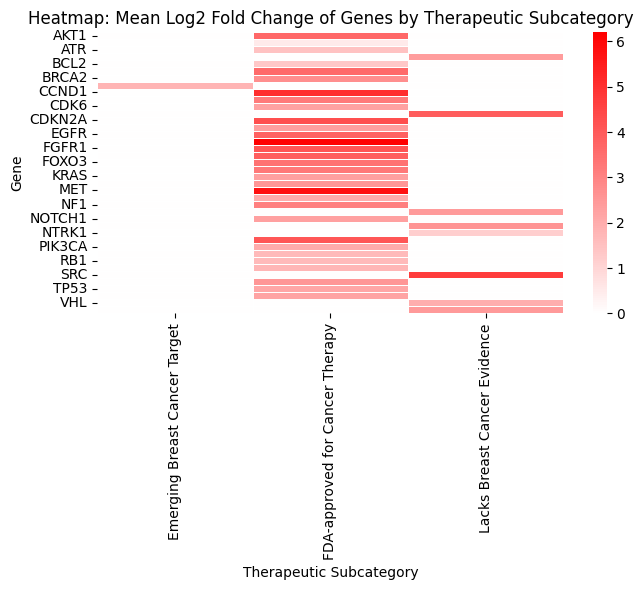

In [56]:
# Prepare pivot table: genes on y-axis, categories/pathways on x-axis, colored by mean log2FC
heatmap_data = df_unique.pivot_table(
    index='Gene',
    columns='Targeting Category',  # or 'Pathway Category'
    values='log2_fc',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(7, 6))
sns.heatmap(heatmap_data, cmap='bwr', center=0, linewidths=0.5)
plt.title("Heatmap: Mean Log2 Fold Change of Genes by Therapeutic Subcategory")
plt.ylabel('Gene')
plt.xlabel('Therapeutic Subcategory')
plt.tight_layout()
plt.show()

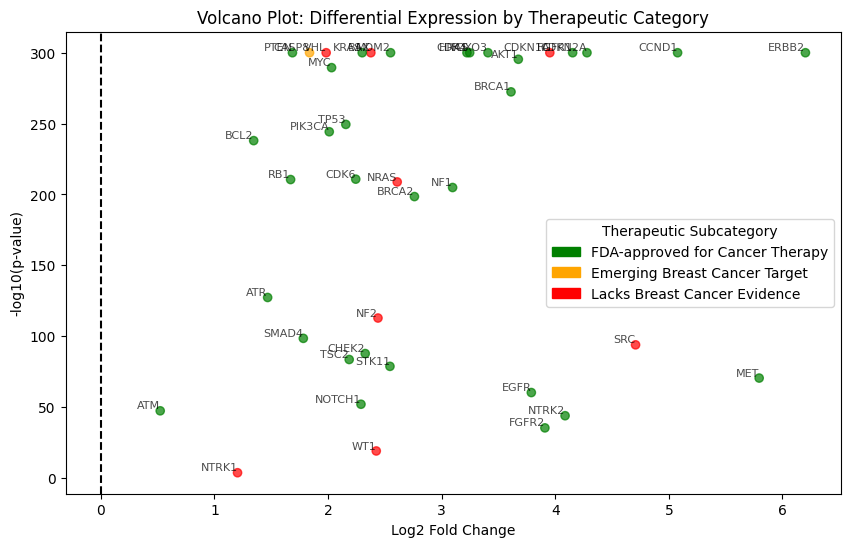

In [57]:
df_unique['-log10_pval'] = -np.log10(df_unique['p_value'] + 1e-300)  # avoid log(0)
plt.figure(figsize=(10, 6))

# Map colors
color_map = {
    'FDA-approved for Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
colors = df_unique['Targeting Category'].map(color_map)

scatter = plt.scatter(df_unique['log2_fc'], df_unique['-log10_pval'],
                        c=colors, alpha=0.7)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Differential Expression by Therapeutic Category')
plt.axvline(0, color='black', linestyle='--')

# Annotate each point with gene name
for i, row in df_unique.iterrows():
    plt.text(row['log2_fc'], row['-log10_pval'], row['Gene'],
                fontsize=8, alpha=0.7, ha='right', va='bottom')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, title="Therapeutic Subcategory", loc='center right')

plt.show()

In [59]:
# Fill NAs for non-FDA approved
df_unique['FDA_Subcategory'] = df_unique['FDA_Subcategory'].fillna('N/A')

# Build label list for nodes
targeting_categories = df_unique['Targeting Category'].unique().tolist()
fda_subcats = df_unique['FDA_Subcategory'].unique().tolist()
trial_status = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['Gene'].unique().tolist()

labels = targeting_categories + fda_subcats + trial_status + genes
label_to_idx = {label: i for i, label in enumerate(labels)}

In [60]:
# Colors for categories (customize as needed)
cat_colors = {
    'FDA-approved for Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red',
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'N/A': 'lightgrey',
    'In Breast Cancer Trial': 'blue',
    'No Breast Cancer Trial': 'grey'
}

# Build links lists: source, target, value, colors
source = []
target = []
value = []
link_colors = []

# Helper function to get color for links (source node color)
def get_link_color(src_label):
    return cat_colors.get(src_label, 'lightgrey')

# Targeting Category → FDA Subcategory
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['FDA_Subcategory']])
    value.append(1)
    link_colors.append(get_link_color(row['Targeting Category']))

# FDA Subcategory → Clinical Trial Status
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['FDA_Subcategory']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(get_link_color(row['FDA_Subcategory']))

# Clinical Trial Status → Gene
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['Gene']])
    value.append(1)
    link_colors.append(get_link_color(row['Clinical_Trial_Status']))

In [61]:
# Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        color=[cat_colors.get(lbl, 'lightgrey') for lbl in labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text="Therapeutic Stratification with FDA Subcategories", font_size=12, height=800, width=1200)
fig.show()

In [62]:
# Filter subsets for each therapeutic group
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved for Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

# For FDA, use 'FDA_Subcategory' as hue
# For emerging and lacks, assign Therapeutic Group label for hue
df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']

df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine all into one DataFrame for plotting
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True).sort_values(by='log2_fc', ascending=False)

# Define color palette
palette = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

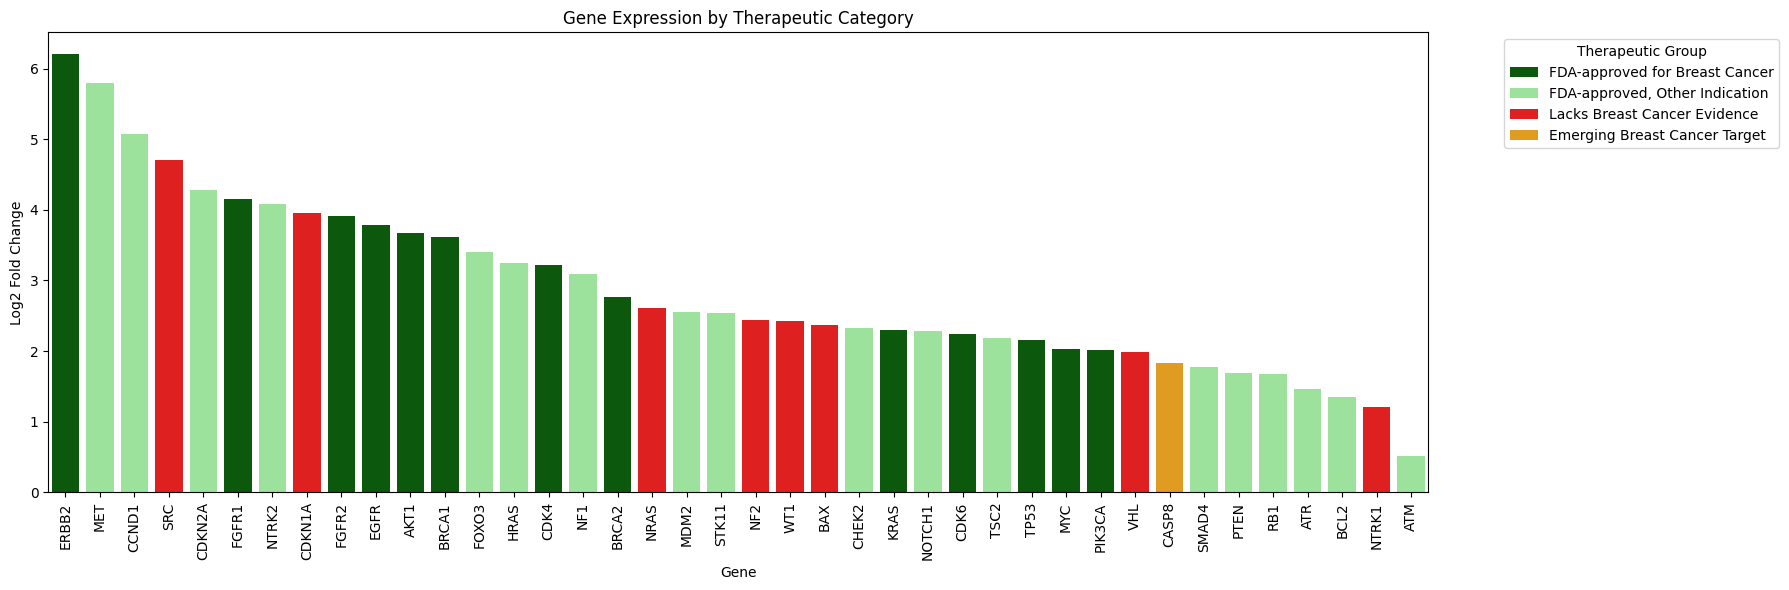

In [63]:
plt.figure(figsize=(18, 6))
sns.barplot(
    data=df_plot,
    x='Gene',
    y='log2_fc',
    hue='Therapeutic Group',
    dodge=False,
    palette=palette
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression by Therapeutic Category')
plt.legend(title='Therapeutic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [67]:
# Filter genes by therapeutic category
genes_fda_bc = df_unique.loc[df_unique['FDA_Subcategory'] == 'FDA-approved for Breast Cancer', 'Gene'].unique().tolist()

genes_fda_other = df_unique.loc[df_unique['FDA_Subcategory'] == 'FDA-approved, Other Indication', 'Gene'].unique().tolist()

genes_emerging = df_unique.loc[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target', 'Gene'].unique().tolist()

genes_lacks = df_unique.loc[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence', 'Gene'].unique().tolist()

print("FDA-approved Breast Cancer Therapy genes:", genes_fda_bc)
print("FDA-approved Other Indication genes:", genes_fda_other)
print("Emerging Breast Cancer Target genes:", genes_emerging)
print("Lacks Breast Cancer Evidence genes:", genes_lacks)

FDA-approved Breast Cancer Therapy genes: ['CDK4', 'FGFR1', 'ERBB2', 'KRAS', 'AKT1', 'MYC', 'BRCA1', 'TP53', 'PIK3CA', 'CDK6', 'BRCA2', 'EGFR', 'FGFR2']
FDA-approved Other Indication genes: ['PTEN', 'CDKN2A', 'MDM2', 'HRAS', 'FOXO3', 'CCND1', 'BCL2', 'RB1', 'NF1', 'ATR', 'SMAD4', 'CHEK2', 'TSC2', 'STK11', 'MET', 'NOTCH1', 'ATM', 'NTRK2']
Emerging Breast Cancer Target genes: ['CASP8']
Lacks Breast Cancer Evidence genes: ['CDKN1A', 'VHL', 'BAX', 'NRAS', 'NF2', 'SRC', 'WT1', 'NTRK1']


In [68]:
print(df_unique['Targeting Category'].unique())

['FDA-approved for Cancer Therapy' 'Lacks Breast Cancer Evidence'
 'Emerging Breast Cancer Target']


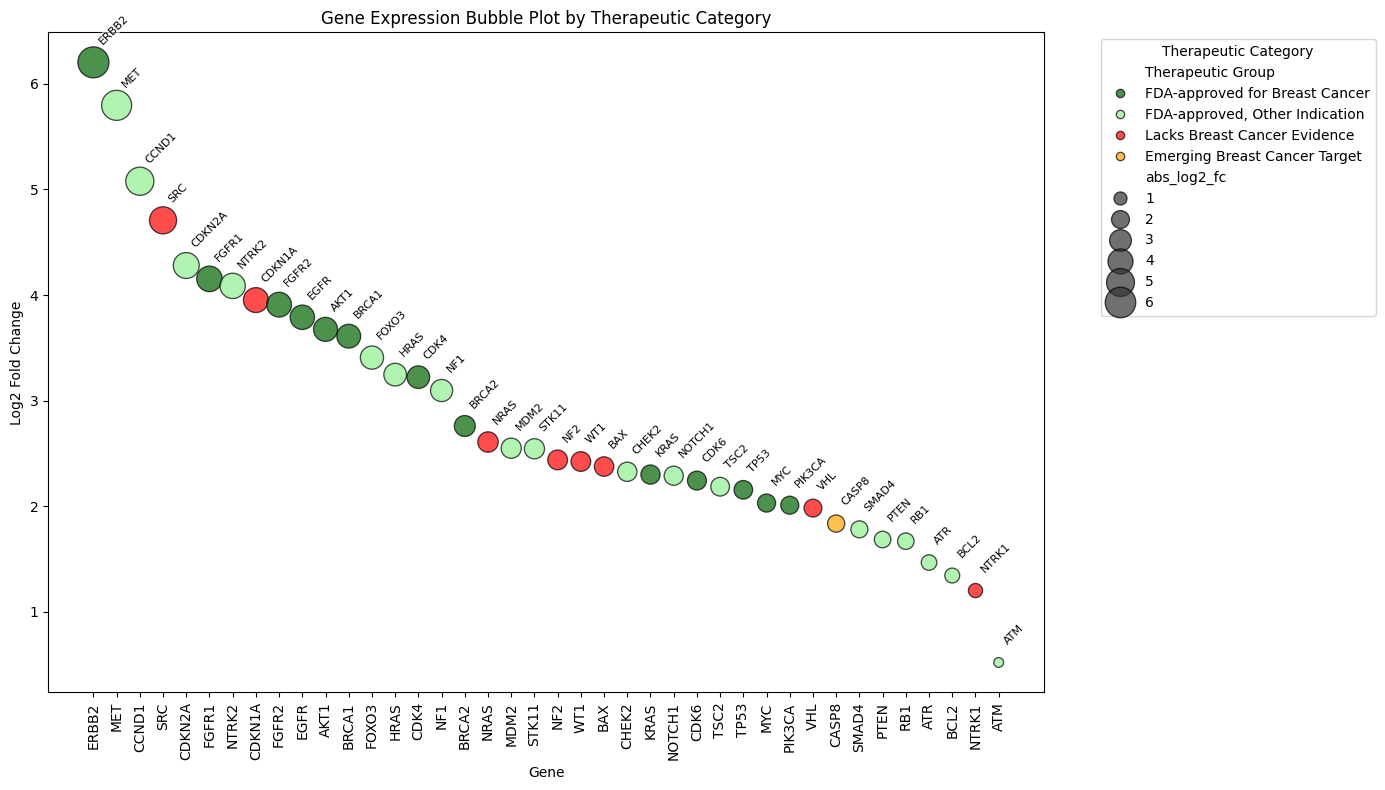

In [69]:
# Prepare absolute log2 fold change for bubble size
df_plot['abs_log2_fc'] = df_plot['log2_fc'].abs()

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_plot,
    x='Gene',
    y='log2_fc',
    size='abs_log2_fc',
    hue='Therapeutic Group',
    palette={
        'FDA-approved for Breast Cancer': 'darkgreen',
        'FDA-approved, Other Indication': 'lightgreen',
        'Emerging Breast Cancer Target': 'orange',
        'Lacks Breast Cancer Evidence': 'red',
    },
    sizes=(50, 500),
    alpha=0.7,
    edgecolor='black',
    legend='brief'  # only hue legend
)

# Adjust legend to show only therapeutic group (hue)
handles, labels = scatter.get_legend_handles_labels()
if labels[0] == 'abs_log2_fc':
    handles = handles[1:]
    labels = labels[1:]

plt.legend(handles, labels, title='Therapeutic Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression Bubble Plot by Therapeutic Category')

# Annotate gene names slightly above and to the right of each bubble with background box
for i in range(df_plot.shape[0]):
    plt.text(
        x=i + 0.15,  # shift slightly right
        y=df_plot['log2_fc'].iloc[i] + 0.15,  # shift slightly above
        s=df_plot['Gene'].iloc[i],
        fontsize=8,
        rotation=45,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

plt.tight_layout()
plt.show()

In [71]:
# Prepare Therapeutic Group as in your bar plot code:
# df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()
# df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
# df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

# df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']
# df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
# df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True)

# Create label list for nodes (Therapeutic Group, Pathway Category, Clinical Trial, Gene)
labels_therapeutic = df_plot['Therapeutic Group'].unique().tolist()
labels_pathway = df_plot['Pathway Category'].unique().tolist()
labels_trial = df_plot['Clinical_Trial_Status'].unique().tolist()
labels_genes = df_plot['Gene'].unique().tolist()

labels = labels_therapeutic + labels_pathway + labels_trial + labels_genes

# Map label to index
label_to_idx = {label: idx for idx, label in enumerate(labels)}

   p_value   log2_fc  mean_diff    Dataset    Gene DGIdb Status  \
0      0.0  1.686214   0.081446  GSE180286    PTEN     Targeted   
1      0.0  3.222505   0.089603  GSE180286    CDK4     Targeted   
2      0.0  4.279113   0.062919  GSE180286  CDKN2A     Targeted   
3      0.0  4.152696   0.070191  GSE180286   FGFR1     Targeted   
4      0.0  2.550032   0.074330  GSE180286    MDM2     Targeted   

   OpenTargets_Score  BreastCancer_Supported  Strong_BreastCancer_Support  \
0           0.774262                    True                         True   
1           0.693263                    True                         True   
2           0.592468                    True                         True   
3           0.501992                    True                         True   
4           0.611441                    True                         True   

  FDA_Approved_Drug               Targeting Category  \
0               Yes  FDA-approved for Cancer Therapy   
1               Yes  F

In [72]:
def get_links(source_col, target_col):
    link_df = df_plot.groupby([source_col, target_col]).size().reset_index(name='count')
    sources = link_df[source_col].map(label_to_idx).tolist()
    targets = link_df[target_col].map(label_to_idx).tolist()
    values = link_df['count'].tolist()
    return sources, targets, values

# Links for Sankey
source_1, target_1, value_1 = get_links('Therapeutic Group', 'Pathway Category')
source_2, target_2, value_2 = get_links('Pathway Category', 'Clinical_Trial_Status')
source_3, target_3, value_3 = get_links('Clinical_Trial_Status', 'Gene')

sources = source_1 + source_2 + source_3
targets = target_1 + target_2 + target_3
values = value_1 + value_2 + value_3

# Color nodes by Therapeutic Group for clarity (optional)
color_map = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
node_colors = []
for label in labels:
    # If therapeutic group, assign color, else default light grey
    node_colors.append(color_map.get(label, 'lightgrey'))

In [73]:
# Color gene links by log2 fold change (blue for down, red for up)
def logfc_to_color(logfc):
    # Normalize logFC for color intensity
    max_val = max(abs(df_plot['log2_fc'].max()), abs(df_plot['log2_fc'].min()))
    norm_val = logfc / max_val
    if norm_val >= 0:
        # Red shades for upregulated
        return f'rgba(255, 0, 0, {0.3 + 0.7 * norm_val})'
    else:
        # Blue shades for downregulated
        return f'rgba(0, 0, 255, {0.3 + 0.7 * abs(norm_val)})'

# Map genes to colors by log2_fc
gene_color_map = dict(zip(df_plot['Gene'], df_plot['log2_fc'].apply(logfc_to_color)))

link_colors = []
for i in range(len(sources)):
    # For links from Clinical Trial Status to Gene, use gene color
    if sources[i] in [label_to_idx[t] for t in labels_trial] and targets[i] in [label_to_idx[g] for g in labels_genes]:
        gene_label = labels[targets[i]]
        link_colors.append(gene_color_map.get(gene_label, 'lightgrey'))
    else:
        link_colors.append('lightgrey')

In [74]:
# Create Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        hovertemplate='%{value} genes<br>From %{source.label} to %{target.label}<extra></extra>'
    )
)])

fig.update_layout(title_text='Therapeutic Stratification Sankey with Log2FC Coloring on Gene Links',
                    font_size=10)

fig.show()

In [75]:
# Show genes grouped by clinical trial status and therapeutic group
trial_summary = df_plot[['Gene', 'Clinical_Trial_Status', 'Therapeutic Group']].copy()

# Sort by Clinical Trial Status and Therapeutic Group
trial_summary = trial_summary.sort_values(by=['Clinical_Trial_Status', 'Therapeutic Group', 'Gene'])

# Print summary
print(trial_summary.to_string(index=False))

  Gene  Clinical_Trial_Status              Therapeutic Group
 CASP8 In Breast Cancer Trial  Emerging Breast Cancer Target
  AKT1 In Breast Cancer Trial FDA-approved for Breast Cancer
 BRCA1 In Breast Cancer Trial FDA-approved for Breast Cancer
 BRCA2 In Breast Cancer Trial FDA-approved for Breast Cancer
  CDK4 In Breast Cancer Trial FDA-approved for Breast Cancer
  CDK6 In Breast Cancer Trial FDA-approved for Breast Cancer
  EGFR In Breast Cancer Trial FDA-approved for Breast Cancer
 ERBB2 In Breast Cancer Trial FDA-approved for Breast Cancer
 FGFR1 In Breast Cancer Trial FDA-approved for Breast Cancer
 FGFR2 In Breast Cancer Trial FDA-approved for Breast Cancer
  KRAS In Breast Cancer Trial FDA-approved for Breast Cancer
   MYC In Breast Cancer Trial FDA-approved for Breast Cancer
PIK3CA In Breast Cancer Trial FDA-approved for Breast Cancer
  TP53 In Breast Cancer Trial FDA-approved for Breast Cancer
   ATM In Breast Cancer Trial FDA-approved, Other Indication
   ATR In Breast Cancer 

___

___

___

# Redesign required below

___

In [80]:
df = pd.read_csv(f"{assets}/Clinical_Trials_Summary.csv")
df.head()

,gene,category,studies,FDA_Approved_Drug,DGIdb_Status,OpenTargets_Score,Strong_BreastCancer_Support,Has_FDA_Drug
0,AKT1,FDA-approved Breast Cancer Therapy,40,No Specific Drug,Targeted,0.812721,True,No
1,ATM,FDA-approved Other Indication,43,No Specific Drug,Targeted,0.810703,True,No
2,ATR,FDA-approved Other Indication,19,No Specific Drug,Targeted,0.525546,True,No
3,BAX,Lacks Breast Cancer Evidence,9,No Specific Drug,Targeted,0.450201,False,No
4,BCL2,FDA-approved Other Indication,24,VENETOCLAX,Targeted,0.542606,True,Yes


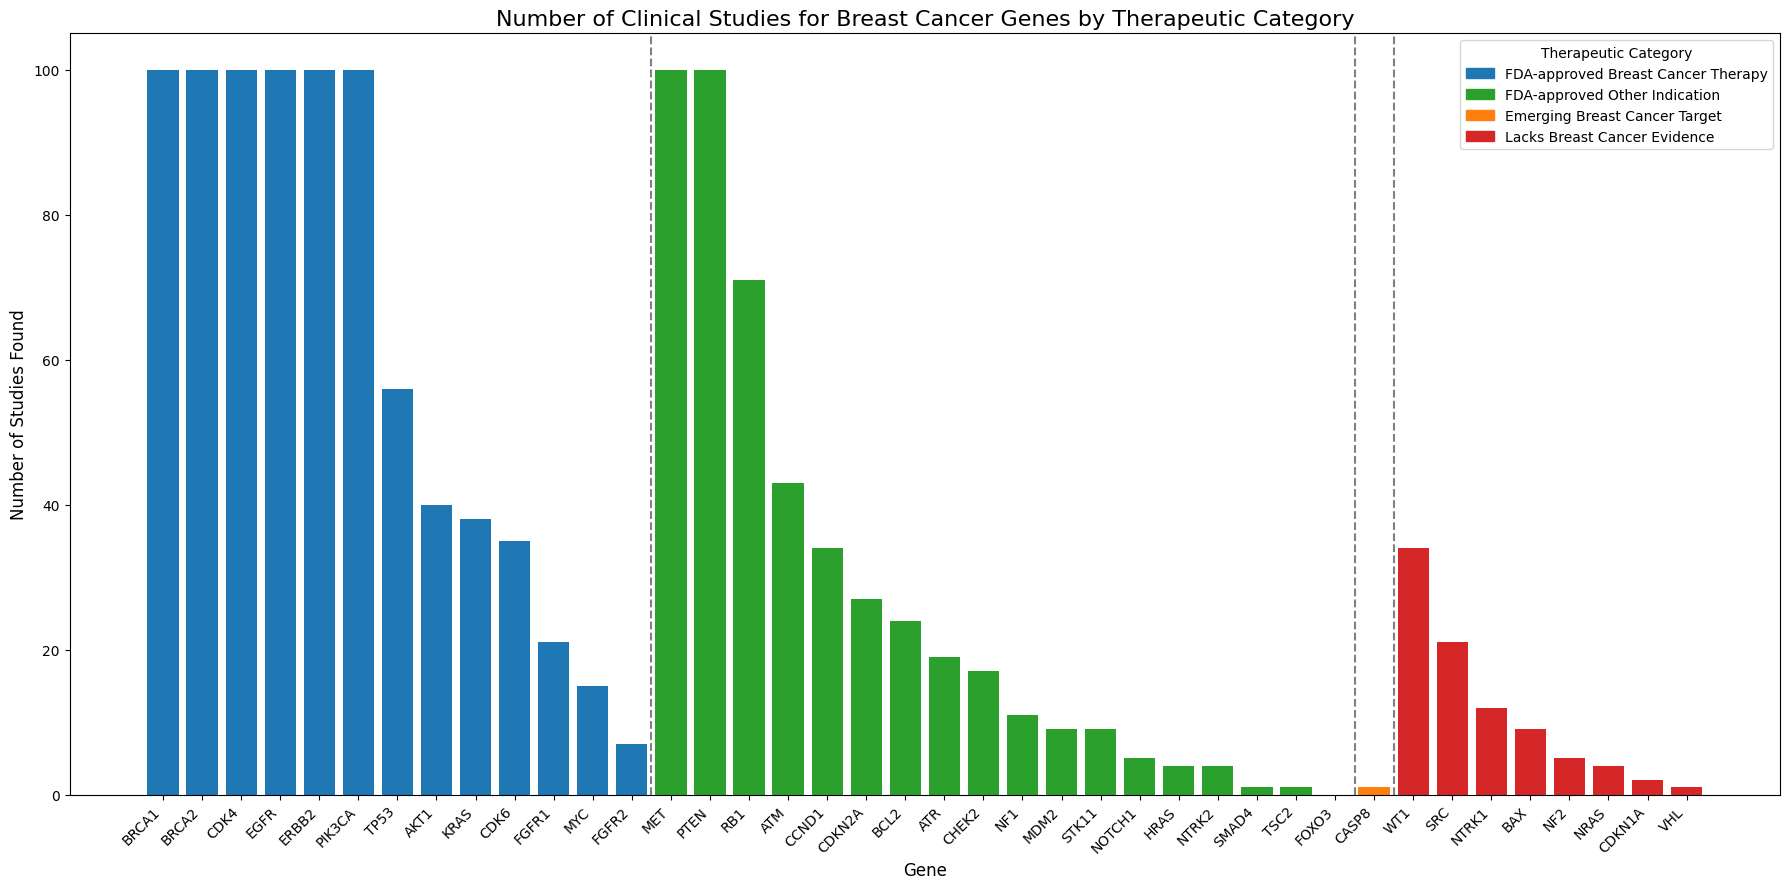

In [81]:
# Sort the data first by category and then by the number of studies within each category.
category_order = [
    'FDA-approved Breast Cancer Therapy', 
    'FDA-approved Other Indication', 
    'Emerging Breast Cancer Target', 
    'Lacks Breast Cancer Evidence'
]
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Create a color map for the categories.
category_colors = {
    'FDA-approved Breast Cancer Therapy': '#1f77b4',  # Blue
    'FDA-approved Other Indication': '#2ca02c',      # Green
    'Emerging Breast Cancer Target': '#ff7f0e',      # Orange
    'Lacks Breast Cancer Evidence': '#d62728'        # Red
}
colors = df['category'].map(category_colors)

# Create the plot.
plt.figure(figsize=(18, 9))
plt.bar(df['gene'], df['studies'], color=colors)

# Add labels and title for clarity.
plt.title('Number of Clinical Studies for Breast Cancer Genes by Therapeutic Category', fontsize=16)
plt.xlabel('Gene', fontsize=12)
plt.ylabel('Number of Studies Found', fontsize=12)

# Rotate x-axis labels to prevent overlap.
plt.xticks(rotation=45, ha='right')

# Add vertical lines to separate the categories.
category_boundaries = df['category'].value_counts(sort=False).cumsum().tolist()
for x_pos in category_boundaries[:-1]:
    plt.axvline(x=x_pos - 0.5, color='gray', linestyle='--', linewidth=1.5)

# Create a custom legend.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_order]
plt.legend(handles, category_order, title="Therapeutic Category")

plt.tight_layout()
plt.show()

In [82]:
# Define the data for the Sankey diagram.
# We will use the same data to build the nodes and links.

# First layer: Genes to Categories
gene_to_category = {
    'CDK4': 'FDA-approved Breast Cancer Therapy', 'ERBB2': 'FDA-approved Breast Cancer Therapy', 'PIK3CA': 'FDA-approved Breast Cancer Therapy',
    'MET': 'FDA-approved Breast Cancer Therapy', 'BRCA1': 'FDA-approved Breast Cancer Therapy', 'BRCA2': 'FDA-approved Breast Cancer Therapy',
    'PTEN': 'FDA-approved Breast Cancer Therapy', 'RB1': 'FDA-approved Breast Cancer Therapy', 'TP53': 'FDA-approved Breast Cancer Therapy',
    'ATM': 'FDA-approved Breast Cancer Therapy', 'AKT1': 'FDA-approved Breast Cancer Therapy', 'KRAS': 'FDA-approved Breast Cancer Therapy',
    'CDK6': 'FDA-approved Breast Cancer Therapy', 'CCND1': 'FDA-approved Other Indication', 'CDKN2A': 'FDA-approved Other Indication',
    'BCL2': 'FDA-approved Other Indication', 'FGFR1': 'FDA-approved Other Indication', 'FGFR2': 'FDA-approved Other Indication',
    'MDM2': 'FDA-approved Other Indication', 'NF1': 'FDA-approved Other Indication', 'HRAS': 'FDA-approved Other Indication',
    'NTRK2': 'FDA-approved Other Indication', 'TSC2': 'FDA-approved Other Indication', 'STK11': 'FDA-approved Other Indication',
    'ATR': 'FDA-approved Other Indication', 'NOTCH1': 'FDA-approved Other Indication', 'SMAD4': 'FDA-approved Other Indication',
    'CHEK2': 'FDA-approved Other Indication', 'CASP8': 'Emerging Breast Cancer Target', 'FOXO3a': 'Emerging Breast Cancer Target',
    'CDKN1A': 'Lacks Breast Cancer Evidence', 'BAX': 'Lacks Breast Cancer Evidence', 'NRAS': 'Lacks Breast Cancer Evidence',
    'VHL': 'Lacks Breast Cancer Evidence', 'SRC': 'Lacks Breast Cancer Evidence', 'NF2': 'Lacks Breast Cancer Evidence',
    'WT1': 'Lacks Breast Cancer Evidence', 'NTRK1': 'Lacks Breast Cancer Evidence'
}

In [83]:
# Second layer: Drugs associated with genes in the FDA-approved categories
gene_to_drug = {
    'CDK4': 'Palbociclib (Ibrance)',
    'CDK6': 'Palbociclib (Ibrance)',
    'ERBB2': 'Trastuzumab (Herceptin)',
    'PIK3CA': 'Alpelisib (Piqray)',
    'BRCA1': 'Olaparib (Lynparza)',
    'BRCA2': 'Olaparib (Lynparza)',
    'MET': 'Crizotinib (Xalkori)',
    'PTEN': 'Alpelisib (Piqray)',  # Drug for PIK3CA pathway
    'KRAS': 'Sotorasib (Lumakras)',
    'BCL2': 'Venetoclax (Venclexta)',
    'NTRK2': 'Larotrectinib (Vitrakvi)',
    'EGFR': 'Gefitinib (Iressa)',
    'TP53': 'Therapies for TP53' # As there is no single FDA-approved drug
}


In [84]:
# Combine all unique genes, categories, and drugs into a single list of labels
all_labels = list(gene_to_category.keys()) + sorted(list(set(gene_to_category.values()))) + sorted(list(set(gene_to_drug.values())))
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Build source, target, and value lists for the links
source = []
target = []
value = []
link_color = []

# Define colors for the links based on the categories
category_colors = {
    'FDA-approved Breast Cancer Therapy': 'rgba(31, 119, 180, 0.8)',  # Blue
    'FDA-approved Other Indication': 'rgba(44, 160, 44, 0.8)',      # Green
    'Emerging Breast Cancer Target': 'rgba(255, 127, 14, 0.8)',      # Orange
    'Lacks Breast Cancer Evidence': 'rgba(214, 39, 40, 0.8)'        # Red
}

# --- First layer of links: Genes to Categories ---
for gene, category in gene_to_category.items():
    source.append(label_to_index[gene])
    target.append(label_to_index[category])
    value.append(1)
    link_color.append(category_colors[category])

# --- Second layer of links: Genes to Drugs (for approved categories) ---
for gene, drug in gene_to_drug.items():
    # Only link genes from the FDA-approved categories to drugs
    if gene_to_category.get(gene) in ['FDA-approved Breast Cancer Therapy', 'FDA-approved Other Indication']:
        source.append(label_to_index[gene])
        target.append(label_to_index[drug])
        value.append(1)
        link_color.append(category_colors[gene_to_category[gene]])


# Create the Sankey diagram figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        # Set node colors based on category
        color=[
            category_colors.get(gene_to_category.get(label), 'lightgray')
            for label in all_labels
        ],
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_color
    )
)])

fig.update_layout(
    title_text="Flow of Genes from Discovery to Clinical Application",
    font_size=10,
    height=800,
    width=1200
)

fig.show()

In [88]:
# --- Re-creating a sample df_unique to demonstrate the code ---
df['studies'] = df['studies'].astype(int)

# --- The refined categorize_gene function with your new rules ---
def categorize_gene(num_studies):
    if num_studies >= 50:
        return 'High-Confidence Targets'
    elif num_studies >= 20:  # Implicitly < 50
        return 'Therapeutic Expansion Targets'
    elif num_studies >= 5:   # Implicitly < 20
        return 'Emerging Clinical Targets'
    else:  # num_studies < 5
        return 'Underexplored Targets'

# Apply categorization to assign each gene to one unique category
df['category'] = df['studies'].apply(categorize_gene)

# Define the order for categories
category_order = [
    'High-Confidence Targets',
    'Therapeutic Expansion Targets',
    'Emerging Clinical Targets',
    'Underexplored Targets'
]

# Sort the DataFrame first by category, then by study count in descending order
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df_summary = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Display the final, sorted DataFrame
display(df_summary)

# Display the final, sorted DataFrame
df_summary.sample(10)
#display(df_summary)

# Sort the DataFrame for a logical flow in the plot.
df = df.sort_values(by='category', ascending=True)
df = df.sort_values(by=['category', 'gene'], ascending=[False,True])

,gene,category,studies,FDA_Approved_Drug,DGIdb_Status,OpenTargets_Score,Strong_BreastCancer_Support,Has_FDA_Drug
5,BRCA1,High-Confidence Targets,100,No Specific Drug,Targeted,0.875045,True,No
6,BRCA2,High-Confidence Targets,100,No Specific Drug,Targeted,0.901557,True,No
9,CDK4,High-Confidence Targets,100,"ABEMACICLIB, RIBOCICLIB SUCCINATE, TRILACICLIB...",Targeted,0.693263,True,Yes
14,EGFR,High-Confidence Targets,100,"AMIVANTAMAB, CETUXIMAB, AFATINIB DIMALEATE, LA...",Targeted,0.698097,True,Yes
15,ERBB2,High-Confidence Targets,100,"TRASTUZUMAB, AFATINIB DIMALEATE, PERTUZUMAB, L...",Targeted,0.820020,True,Yes
30,PIK3CA,High-Confidence Targets,100,"COPANLISIB HYDROCHLORIDE, COPANLISIB, ALPELISIB",Targeted,0.855934,True,Yes
22,MET,High-Confidence Targets,100,"AMIVANTAMAB, CAPMATINIB, CABOZANTINIB S-MALATE...",Targeted,0.539556,True,Yes
31,PTEN,High-Confidence Targets,100,No Specific Drug,Targeted,0.774262,True,No
32,RB1,High-Confidence Targets,71,No Specific Drug,Targeted,0.696427,True,No
36,TP53,High-Confidence Targets,56,No Specific Drug,Targeted,0.852160,True,No


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_18572\2123317642.py:32: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



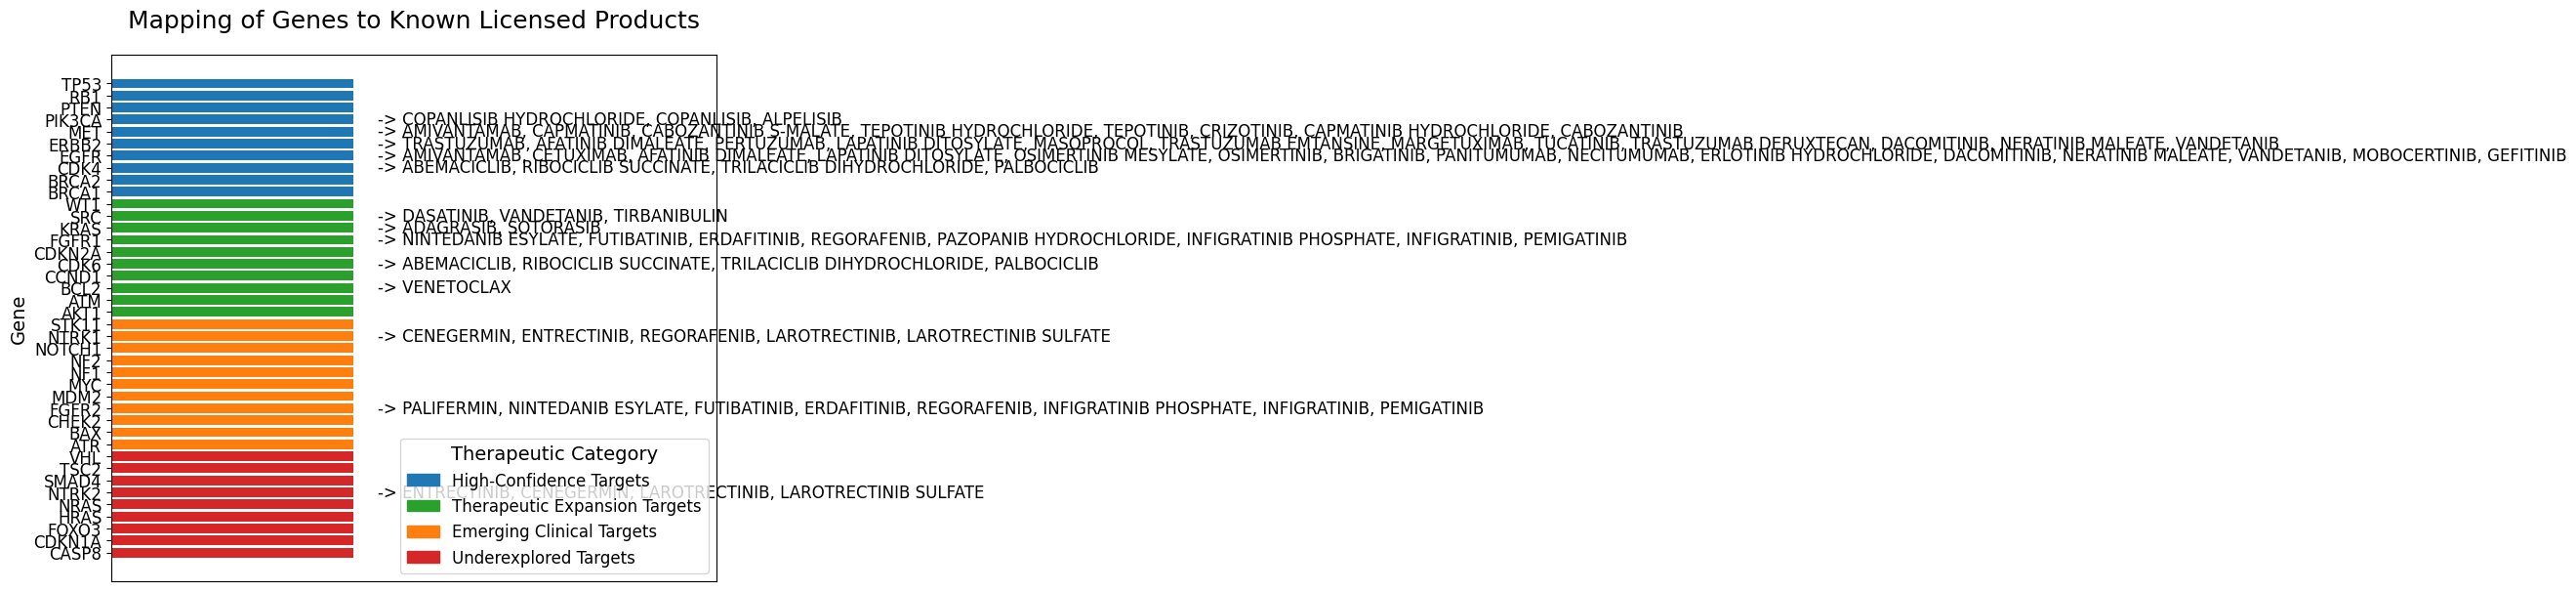

In [92]:
# Create a color map for the plot based on your four categories.
category_colors = {
    'High-Confidence Targets': '#1f77b4',       # Blue
    'Therapeutic Expansion Targets': '#2ca02c', # Green
    'Emerging Clinical Targets': '#ff7f0e',     # Orange
    'Underexplored Targets': '#d62728'          # Red
}
colors = df['category'].map(category_colors)

# --- Create the Plot ---
plt.figure(figsize=(8, 7))
# The bar height is a placeholder to control bar order.
plt.barh(df['gene'], [1] * len(df), color=colors)  

# Add text labels for the drug names.
for i, (gene, drug) in enumerate(zip(df['gene'], df['FDA_Approved_Drug'])):
    if drug != 'No Specific Drug':
        plt.text(1.1, i, f'-> {drug}', va='center', fontsize=12, color='black')

# Set labels, title, and other plot aesthetics.
plt.title('Mapping of Genes to Known Licensed Products', fontsize=18, pad=20)
plt.xlabel('Category & Drug Status', fontsize=14)
plt.ylabel('Gene', fontsize=14)
plt.yticks(fontsize=12)
plt.xlim(0, 2.5)  # Adjust x-limit to make space for the drug names
plt.gca().get_xaxis().set_visible(False)  # Hide x-axis

# Create a custom legend with all four categories.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_colors]
plt.legend(handles, category_colors.keys(), title="Therapeutic Category", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

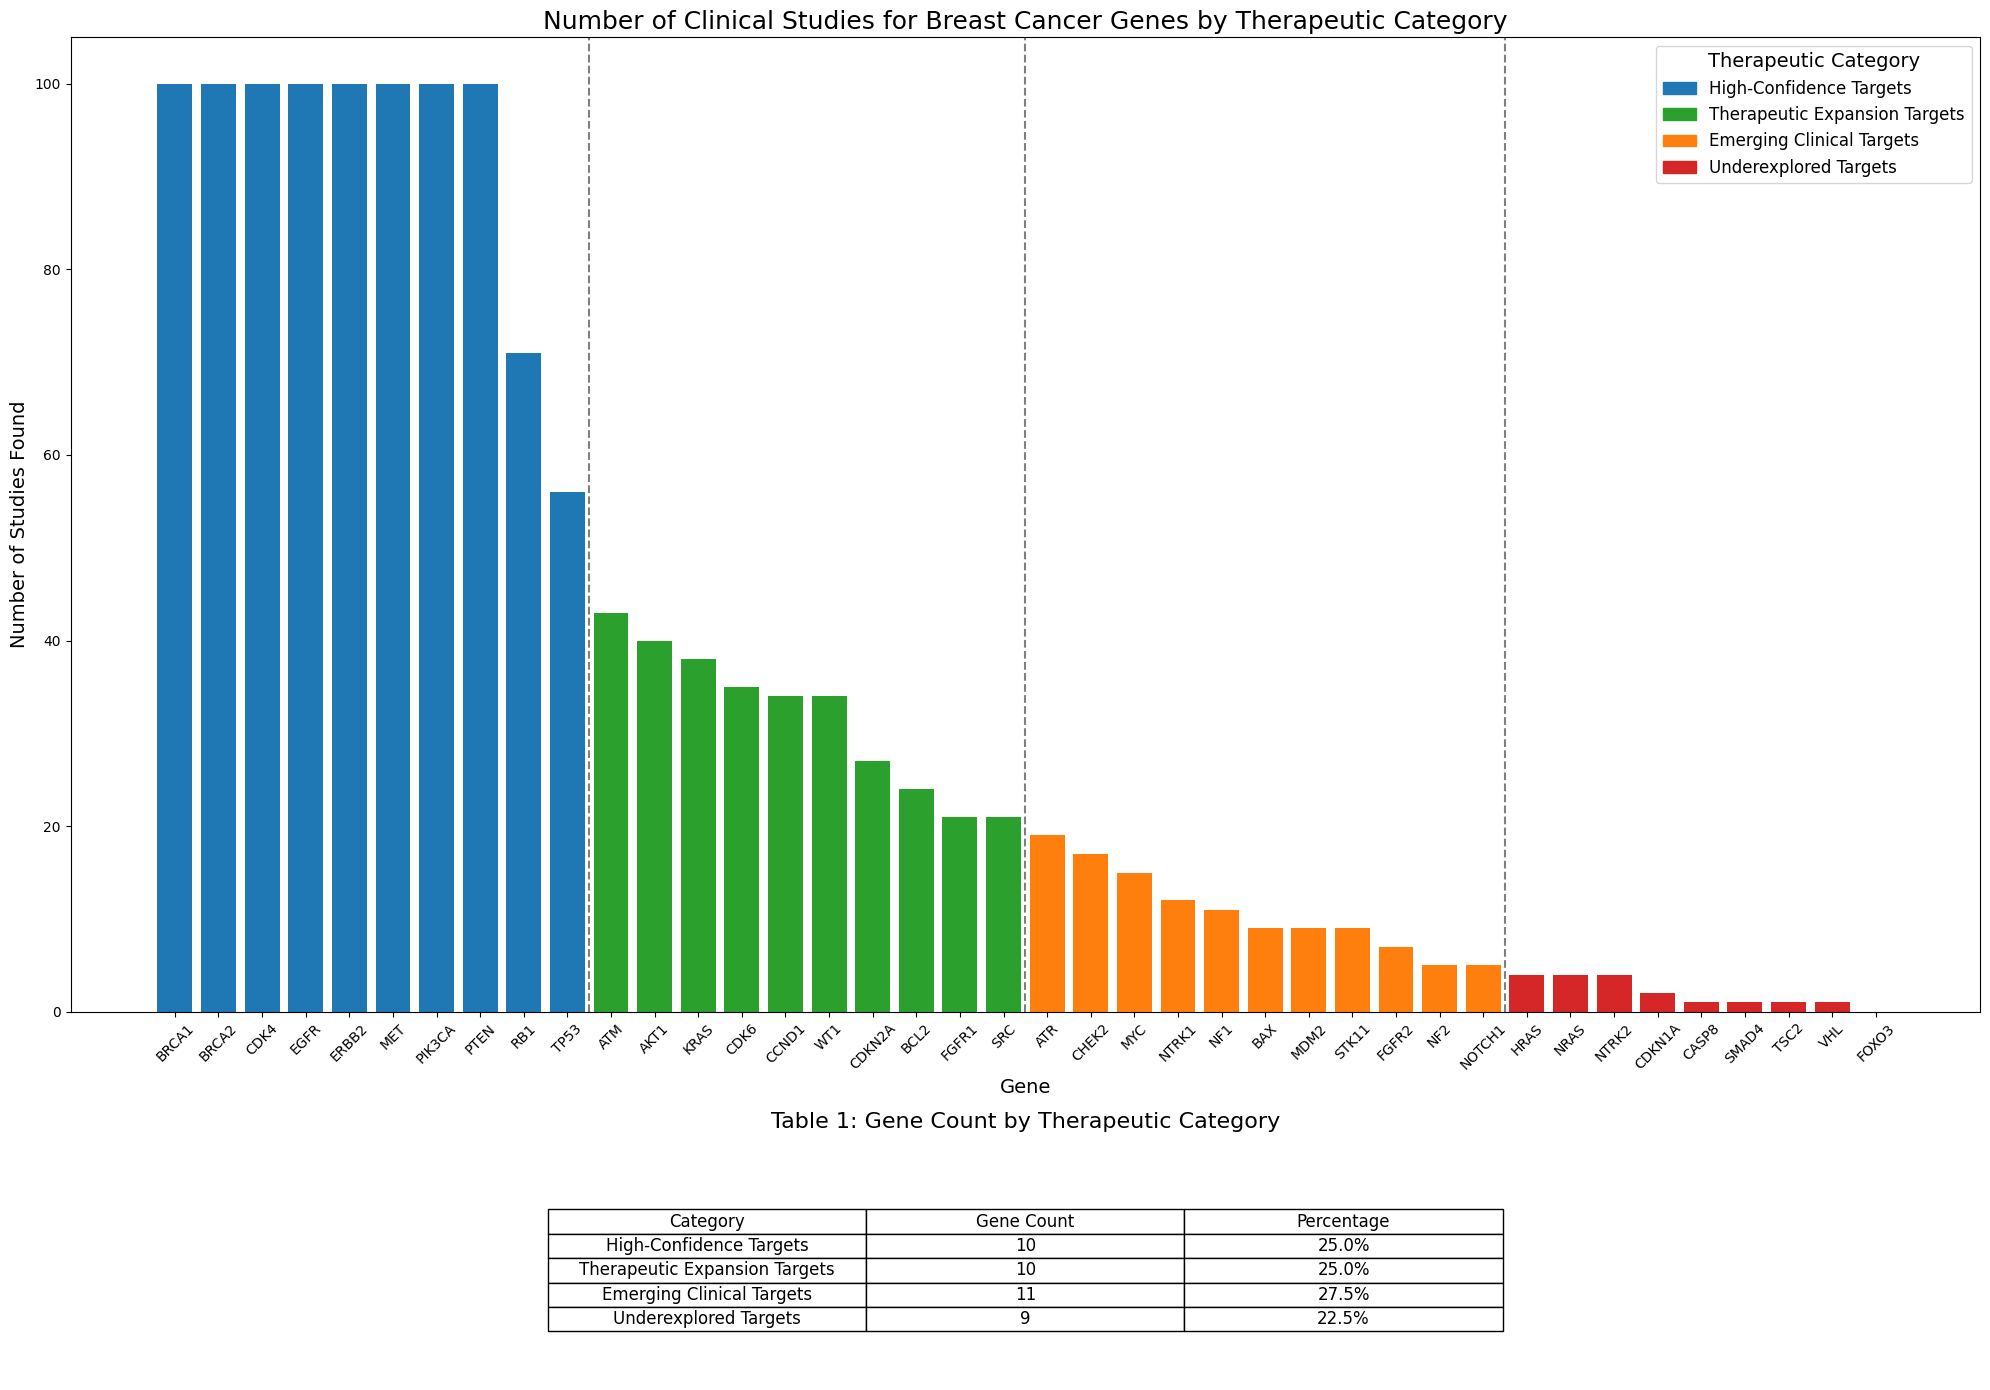

In [ ]:
# Sort the data first by category order and then by study count within each category.
category_order = [
    'High-Confidence Targets', 
    'Therapeutic Expansion Targets', 
    'Emerging Clinical Targets', 
    'Underexplored Targets'
]
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Create a color map for the categories.
category_colors = {
    'High-Confidence Targets': '#1f77b4',       # Blue
    'Therapeutic Expansion Targets': '#2ca02c', # Green
    'Emerging Clinical Targets': '#ff7f0e',     # Orange
    'Underexplored Targets': '#d62728'          # Red
}
colors = df['category'].map(category_colors)

# Create the plot.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14), gridspec_kw={'height_ratios': [1, 0.25]})

# Plot the bar chart on the first axes (ax1).
ax1.bar(df['gene'], df['studies'], color=colors)
ax1.set_title('Number of Clinical Studies for Breast Cancer Genes by Therapeutic Category', fontsize=18)
ax1.set_xlabel('Gene', fontsize=14)
ax1.set_ylabel('Number of Studies Found', fontsize=14)

# Corrected plt.xticks to remove the problematic 'ha' keyword
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Add vertical lines to separate the categories.
category_boundaries = df['category'].value_counts(sort=False).cumsum().tolist()
for x_pos in category_boundaries[:-1]:
    ax1.axvline(x=x_pos - 0.5, color='gray', linestyle='--', linewidth=1.5)

# Create a custom legend with all four categories.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_order]
ax1.legend(handles, category_order, title="Therapeutic Category", fontsize=12, title_fontsize=14)

# --- Create the supplementary table on the second axes (ax2) ---
ax2.set_title('Table 1: Gene Count by Therapeutic Category', fontsize=16)
ax2.axis('off') # Hide axes for the table

# Calculate the count and percentage for each category.
category_counts = df['category'].value_counts().to_frame().reset_index()
category_counts.columns = ['Category', 'Gene Count']
total_genes = category_counts['Gene Count'].sum()
category_counts['Percentage'] = (category_counts['Gene Count'] / total_genes * 100).round(1).astype(str) + '%'

# Reorder the table to match the plot.
category_counts['Category'] = pd.Categorical(category_counts['Category'], categories=category_order, ordered=True)
category_counts = category_counts.sort_values(by='Category')

# Create the table
table = ax2.table(cellText=category_counts.values, colLabels=category_counts.columns, cellLoc='center', loc='center', bbox=[0.25, 0.2, 0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()

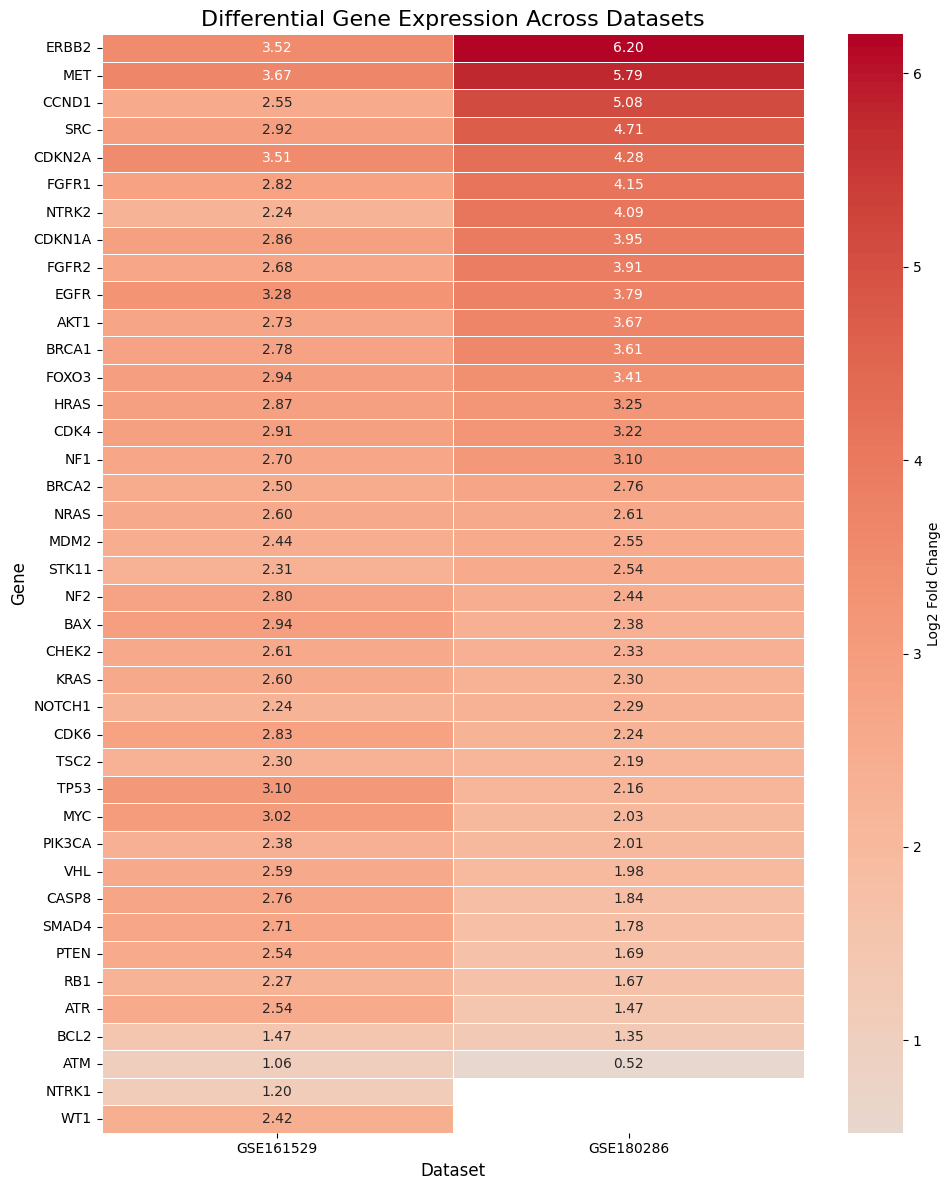

In [96]:
# Sort df_pivot rows by 'GSE180286' column descending

# Pivot the dataframe: index=gene, columns=Dataset, values=log2_fc
df = pd.read_csv(f"{assets}/Combined_DE.csv")
df_pivot = df.pivot(index='gene', columns='Dataset', values='log2_fc')
df_pivot_sorted = df_pivot.sort_values(by='GSE180286', ascending=False)

plt.figure(figsize=(10, max(4, len(df_pivot_sorted)*0.3)))  # dynamic height

sns.heatmap(
    df_pivot_sorted,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log2 Fold Change'}
)

plt.title('Differential Gene Expression Across Datasets', fontsize=16)
plt.ylabel('Gene', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.show()

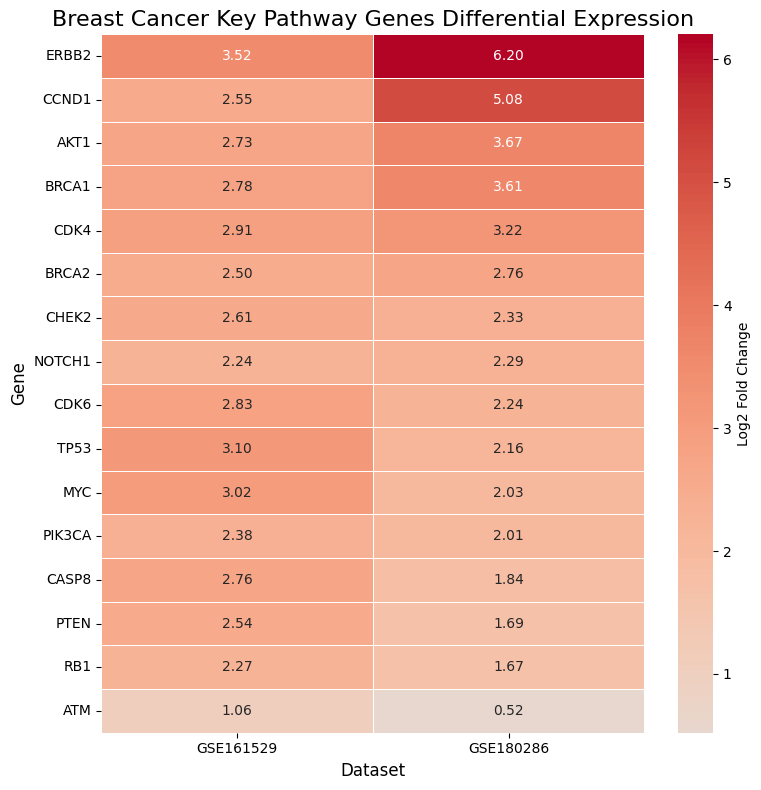

In [ ]:
# Your core breast cancer genes — you can add more if desired
genes = [
    'ESR1', 'PGR', 'PIK3CA', 'AKT1', 'CDK4', 'CDK6', 'CCND1', 'RB1',
    'PTEN', 'FOXO3a', 'CASP8', 'TP53',
    # Additional important breast cancer genes
    'BRCA1', 'BRCA2', 'MYC', 'HER2', 'ERBB2', 'NOTCH1', 'MTOR', 'CHEK2', 'ATM'
]

# Load your combined DE genes DataFrame
#df = pd.read_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv")

# Normalize gene names (optional but recommended)
df['gene_norm'] = df['gene'].str.upper().str.strip()

# Filter for genes of interest (case-insensitive match)
genes_upper = [g.upper() for g in genes]
df_filtered = df[df['gene_norm'].isin(genes_upper)]

# Pivot to get genes as rows, datasets as columns with log2_fc values
df_pivot = df_filtered.pivot(index='gene_norm', columns='Dataset', values='log2_fc')

# Sort by GSE180286 descending
df_pivot_sorted = df_pivot.sort_values(by='GSE180286', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, max(4, len(df_pivot_sorted)*0.5)))

sns.heatmap(
    df_pivot_sorted,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log2 Fold Change'}
)

plt.title('Breast Cancer Key Pathway Genes Differential Expression', fontsize=16)
plt.ylabel('Gene', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.show()